# Sampta Experience II

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch_harmonics as th
import spherical_inr as sph
from sklearn.preprocessing import MinMaxScaler
import pyshtools

In [32]:
def compute_snr(image, noisy_image):
    """
    Computes the Signal-to-Noise Ratio (SNR) between two images.
    """
    
    signal_power = torch.mean(torch.square(image))
    noise_power = torch.mean(torch.square(image - noisy_image))
    snr = 10 * torch.log10(signal_power / noise_power)
    
    return snr

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Data Preprocessing 

In [76]:
lmax = 30
coefficients = pyshtools.datasets.Earth.Earth2014.tbi(lmax = lmax)

In [83]:
phi_train, theta_train, (nlon, nlat) = sph.sample_s2(2*lmax, sampling = "gl", torch_tensor = True)
data_train = coefficients.expand(lon = phi_train.numpy().flatten(),  colat = theta_train.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat, nlon)

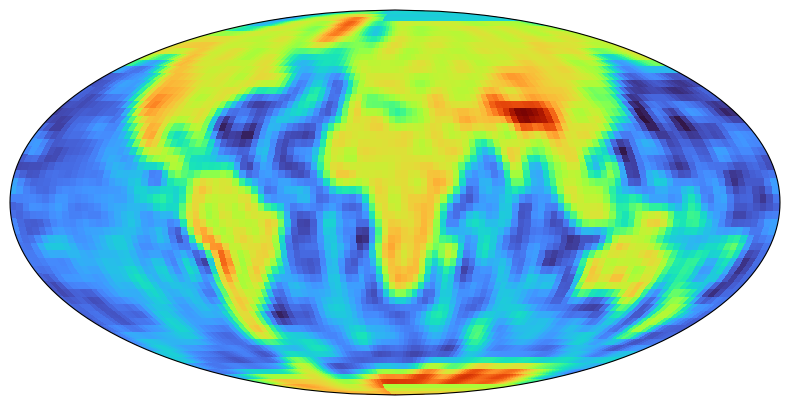

In [84]:
fig = plt.figure(figsize=(10, 5))
sph.plot_sphere(data_train, fig = fig, cmap  = "turbo", molweide=True)
plt.show()

In [98]:
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train.reshape(-1, 1)).flatten()

X = torch.stack([theta_train.flatten(), phi_train.flatten()], dim=-1).float()
y = torch.tensor(data_train_scaled.copy()).flatten().unsqueeze(1).float()
y_unscaled = torch.tensor(data_train.copy()).reshape(nlat, nlon)

X, y = X.to(device), y.to(device)
y_unscaled = y_unscaled.to(device)

## Model Parameter

In [113]:
## Model parameters
Q = 2                   # number of hidden layer
HIDDEN_FEATURES = 50    # number of hidden features

## Training parameters
BATCH_SIZE = 1024
EPOCHS = 200

In [141]:
from itertools import product
degrees_supports = [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (15, 2), (20, 2), (30, 2)]
L0s = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
grid = list(product(degrees_supports, L0s)) 

In [143]:
N_EXP = 5
SNRs = {(degree_supp[0], l0) : [] for degree_supp, l0 in grid}


for (d, supp), l0 in grid:
    for _ in range(N_EXP):

        model = sph.SphericalNet(
            Q  = Q, 
            L0 = l0,
            hidden_features = HIDDEN_FEATURES,
            bias = False, 
            activation = sph.Chebyshev(order = d, alpha = supp),
            spectral_norm = True, 
            device = device
        )


        sph.train(
            model = model, 
            x = X,
            y = y,
            epochs = EPOCHS,
            batch_size = BATCH_SIZE,
            optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
            loss_fn = torch.nn.MSELoss(),
        )

        y_pred_scaled = model(X).detach().cpu().numpy().flatten()
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(nlat, nlon)
        SNRs[(d, l0)].append(compute_snr(y_unscaled, y_pred))

In [117]:
import json
json_serializable_dict = {str(key): value for key, value in SNRs.items()}

# Save to a JSON file
with open("results/SNRs_grid.json", "w") as json_file:
    json.dump(json_serializable_dict, json_file, indent=4)

print("SNRs saved to SNRs.json")

TypeError: Object of type Tensor is not JSON serializable

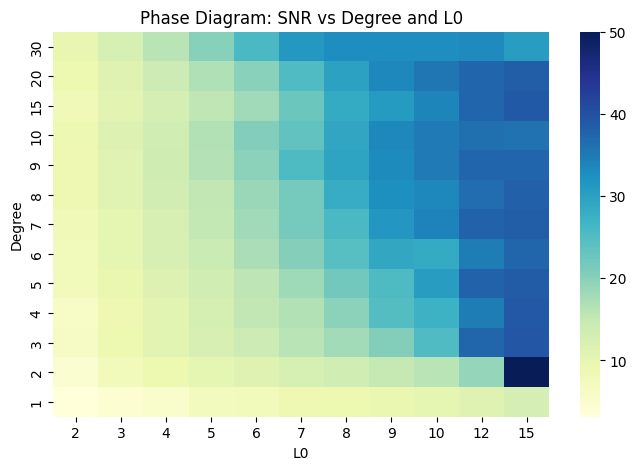

In [147]:
import seaborn as sns

# Extract the degrees and l0s from the grid
degrees = sorted(set(degree_supp[0] for degree_supp, l0 in grid), reverse=True)
l0s = sorted(set(l0 for degree_supp, l0 in grid))

# Create a matrix to hold the mean SNR values
snr_matrix = np.zeros((len(degrees), len(l0s)))

# Fill the matrix with the mean SNR values
for i, d in enumerate(degrees):
    for j, l0 in enumerate(l0s):
        snr_matrix[i, j] = np.mean(SNRs[(d, l0)])

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(snr_matrix, xticklabels=l0s, yticklabels=degrees, cmap="YlGnBu", vmax = 50)
plt.title("Phase Diagram: SNR vs Degree and L0")
plt.xlabel("L0")
plt.ylabel("Degree")
plt.show()
